# Content-based Filtering

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

# Reading data

In [2]:
train_df = pd.read_csv("D:/Master/FSS_25/Web_Mining/Project/data/dataset_baseline/rec_train_preprocessed_binned.csv")
test_df = pd.read_csv("D:/Master/FSS_25/Web_Mining/Project/data/dataset_baseline/rec_test_preprocessed_binned.csv")
beers_df = pd.read_csv("D:/Master/FSS_25/Web_Mining/Project/data/cleaned_beers.csv")

beers_df = beers_df.rename(columns={'id': 'beer_id'})
merged_df = train_df.merge(beers_df, how='left', on='beer_id')
beers_df

,beer_id,style,availability,country,abv
0,267989,American IPA,Rotating,CA,5.900000
1,343558,American IPA,Rotating,US,6.500000
2,302786,American IPA,Rotating,US,5.600000
3,153878,American IPA,Limited (brewed once),US,7.600000
4,75066,American IPA,Fall,US,7.200000
...,...,...,...,...,...
92415,367916,Wild/Sour Beers,Limited (brewed once),US,5.500000
92416,367956,Wild/Sour Beers,Rotating,US,6.000000
92417,367929,Wild/Sour Beers,Limited (brewed once),US,5.200000
92418,367924,Wild/Sour Beers,Rotating,US,5.700000


In [36]:
train_df

,beer_id,username,date,text,look,smell,taste,feel,overall,score,sentiment,has_look,has_smell,has_taste,has_feel,mentioned_aspects,score_bin
0,62040,GregSVT,2010-10-29,22oz bomber snifter a: pours murky amber nice ...,4.00,4.50,4.50,4.00,4.00,4.32,positive,True,True,True,True,"look, smell, taste, feel","[4.0, 4.5)"
1,292393,NeroFiddled,2018-08-09,"avery brewing co. ""bug zapper"" 12 fl. oz. can,...",4.25,4.00,4.25,4.25,4.00,4.14,positive,True,True,True,True,"look, smell, taste, feel","[4.0, 4.5)"
2,55291,matjack85,2011-07-06,"found single, clear, 330ml bottle binny's stor...",2.00,2.00,2.00,2.00,1.50,1.90,negative,True,True,True,True,"look, smell, taste, feel","[1.5, 2.0)"
3,223330,BlurryVisi0n,2016-07-21,served chalice glass bottle cerveceria esparte...,4.00,4.25,4.00,4.50,4.00,4.11,positive,True,True,True,True,"look, smell, taste, feel","[4.0, 4.5)"
4,222637,Brutaltruth,2018-09-18,12 oz bottle snifter. decent bock pours nice c...,4.25,3.25,3.25,3.50,3.25,3.34,neutral,True,True,True,True,"look, smell, taste, feel","[3.0, 3.5)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,612,number1bum,2007-08-30,part nepa bc split #6. pours clear golden colo...,4.00,3.50,4.00,3.00,3.50,3.68,neutral,True,True,True,True,"look, smell, taste, feel","[3.5, 4.0)"
15996,5,damndirtyape,2010-11-13,single bottle (best 01/25/11) poured shaker pi...,4.00,3.50,3.50,4.00,4.50,3.78,neutral,True,True,True,True,"look, smell, taste, feel","[3.5, 4.0)"
15997,25608,CloudStrife,2013-09-01,"12oz bottle poured snifter. best jan 31, 2014....",4.00,3.25,3.50,3.50,3.50,3.47,neutral,True,True,True,True,"look, smell, taste, feel","[3.0, 3.5)"
15998,30517,Thorpe429,2010-10-06,2006 vintage opened drabmuh recent tasting. po...,4.00,4.50,4.50,4.50,4.00,4.37,positive,True,True,True,True,"look, smell, taste, feel","[4.0, 4.5)"


# Beer Feature Encoding

In [ ]:
beer_feature_cols = ['beer_id', 'style', 'availability', 'country', 'abv']
beers_df = beers_df[beer_feature_cols].drop_duplicates(subset='beer_id')

In [ ]:
categorical_cols = ['style', 'availability', 'country']
numerical_cols = ['abv']

# One-hot encode categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = ohe.fit_transform(beers_df[categorical_cols])

# Min-Max scale numerical features
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(beers_df[numerical_cols])

# Concatenate all structural features into a single vector
beer_vectors = np.hstack((numerical_scaled, categorical_encoded))
beer_ids = beers_df['beer_id'].values

# Construct beer_id → feature vector mapping
beer_id_to_vector = dict(zip(beer_ids, beer_vectors))

# User Profile

In [39]:
user_profiles = {}

for user in train_df['username'].unique():
    user_reviews = train_df[(train_df['username'] == user) & (train_df['overall'] >= 3)]
    beer_vecs = np.array([
        beer_id_to_vector[b] for b in user_reviews['beer_id'].values if b in beer_id_to_vector
    ])
    
    if len(beer_vecs) > 0:
        user_profiles[user] = np.mean(beer_vecs, axis=0)

# Recommendation Generation

In [ ]:
recommendations = {}

for user, profile in user_profiles.items():
    profile = profile.reshape(1, -1)
    
    # Compute similarity scores
    all_vectors = np.array(list(beer_id_to_vector.values()))
    all_ids = list(beer_id_to_vector.keys())
    sim_scores = cosine_similarity(profile, all_vectors).flatten()
    
    sim_df = pd.DataFrame({'beer_id': all_ids, 'score': sim_scores})
    
    # Filter out beers already rated by the user
    rated = train_df[train_df['username'] == user]['beer_id'].tolist()
    sim_df = sim_df[~sim_df['beer_id'].isin(rated)]
    
    # Select Top-10 recommendations
    top_beers = sim_df.sort_values(by='score', ascending=False).head(10)['beer_id'].tolist()
    recommendations[user] = top_beers

In [41]:
ground_truth = test_df.groupby('username')['beer_id'].apply(set).to_dict()

# Evaluation

MSE: 6.169
RMSE: 2.484
MAE: 2.185


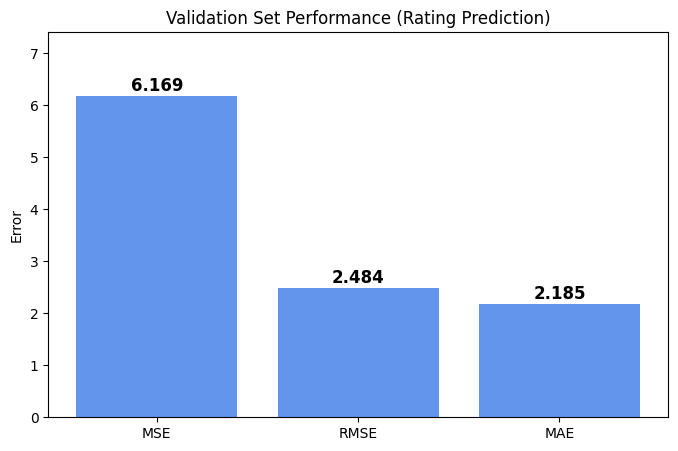

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

test_df['predicted_rating'] = test_df.apply(lambda row: 
    np.dot(user_profiles[row['username']], beer_id_to_vector[row['beer_id']])
    if row['username'] in user_profiles and row['beer_id'] in beer_id_to_vector
    else np.nan, axis=1)

valid_df = test_df[['overall', 'predicted_rating']].dropna()

y_true = valid_df['overall'].values
y_pred = valid_df['predicted_rating'].values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

plt.figure(figsize=(8, 5))
metrics = ['MSE', 'RMSE', 'MAE']
values = [mse, rmse, mae]
bars = plt.bar(metrics, values, color='cornflowerblue')

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Error')
plt.title('Validation Set Performance (Rating Prediction)')
plt.ylim(0, max(values)*1.2)
plt.show()

In [43]:
def precision_at_k(recommendations, ground_truth, k=10):
    precisions = []
    for user, recs in recommendations.items():
        if user not in ground_truth:
            continue
        top_k = recs[:k]
        hits = len(set(top_k) & ground_truth[user])
        precisions.append(hits / k)
    return np.mean(precisions)

In [44]:
def ndcg_at_k(recommendations, ground_truth, k=10):
    def dcg(recommended, relevant):
        return sum([
            1 / np.log2(idx + 2)
            for idx, item in enumerate(recommended)
            if item in relevant
        ])
    
    scores = []
    for user, recs in recommendations.items():
        if user not in ground_truth:
            continue
        top_k = recs[:k]
        actual_dcg = dcg(top_k, ground_truth[user])
        ideal_dcg = dcg(sorted(ground_truth[user], key=lambda x: 1, reverse=True)[:k], ground_truth[user])
        ndcg = actual_dcg / ideal_dcg if ideal_dcg > 0 else 0
        scores.append(ndcg)
    return np.mean(scores)

In [45]:
prec = precision_at_k(recommendations, ground_truth, k=10)
ndcg = ndcg_at_k(recommendations, ground_truth, k=10)

print("Top-N Evaluation:")
print(f"Precision@10: {prec:.4f}")
print(f"NDCG@10: {ndcg:.4f}")


Top-N Evaluation:
Precision@10: 0.0003
NDCG@10: 0.0009
